In [ ]:
# instructions:
#figure out your parameters in the single version, parameters go in the variables minmass, maxsize and noise size
#place files in the same folder and the script will find them.
#the first block does all the tracking and it takes a while
#second graphs so you dont have to wait to track again if you want to change the plot.

In [1]:

%pylab inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdz
from pandas import DataFrame, Series  # for convenience
import IPython
import pims
import trackpy as tp
import av
import os
from os import listdir
from os.path import isfile, join, abspath, basename

mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

##############Crop and greyscale pipelines#######################
@pims.pipeline
def gray(image):
    return image[:, :, 2]  # Take just the green channel

@pims.pipeline
def crop(image,xmin,xmax,ymin,ymax):
    return image[xmin:xmax,ymin:ymax]
##################################################################


#tuning variables, pick these with single particle tracking notebook#
minmass = 80 #scales with the size
maxsize = 18
noise_size = 3
aproxsize = 7 #must be odd
mpp = 100 #microns per pixel
######################################################################


try:
    path = sys.path[0]
    allfiles = [f for f in listdir(path) if isfile(join(path, f))]
    files = [ fi for fi in allfiles if fi.endswith(".tif") ]
    print("files opened succesfully")
    print("files: ",files)
except:
    print("oh no error opening files")



Populating the interactive namespace from numpy and matplotlib
files opened succesfully
files:  ['Z-stack_2020-10-09_13.58.59-006.ims - C=1.tif']


In [2]:
t1 =[] #tracks storage
filenames = []

for fl in files:
    print(abspath(fl))
    filenames.append(basename(abspath(fl)))
    vid = pims.open(basename(abspath(fl))) #pims changes the working directory when doing this
    f = tp.batch(vid, aproxsize, invert=True, minmass=minmass, maxsize=maxsize, noise_size=noise_size)
    t = tp.link(f, 15, memory=2) #link them together
    t1.append(tp.filter_stubs(t, 5)) #gets rid of small trajectories

Frame 198: 5 trajectories present.


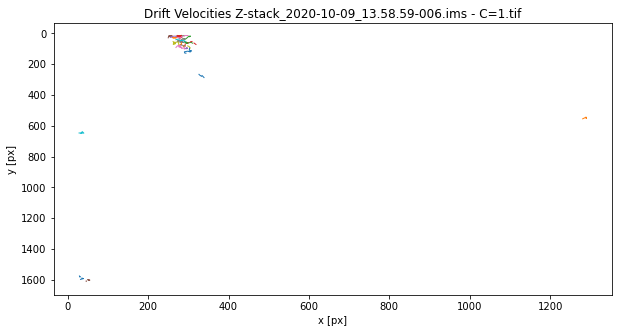

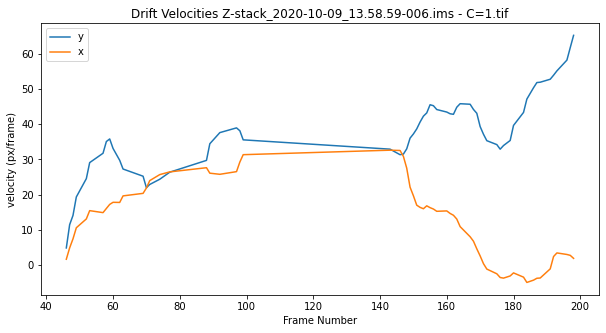

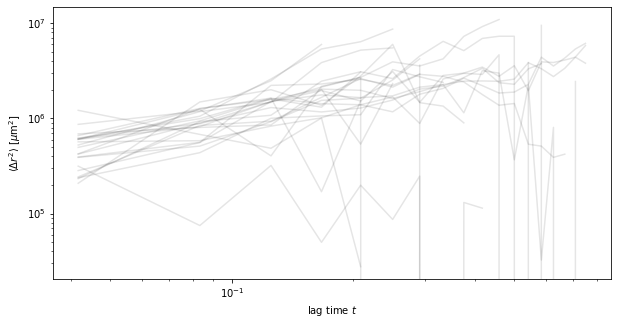

In [6]:
#makes plots
os.chdir(path)
plotspath = os.path.join(path,"Plots")
if os.path.exists(plotspath):
    os.chdir(plotspath)
else:
    os.mkdir(plotspath)
    os.chdir(plotspath)
for i, tra in enumerate(t1):
    plt.figure()
    plt.xlabel("Frame Number")
    plt.ylabel("velocity (px/frame)")
    plt.title("Drift Velocities "+ filenames[i])
    tp.plot_traj(tra); #plotting pretty lines
#    plt.savefig("Lines "+ filenames[i]+".png", format='png') #this doesnt work bc trackpy is being weird
#    plt.show()


    d = tp.compute_drift(tra, smoothing = 5) #find drift
    d.plot()
    plt.xlabel("Frame Number")
    plt.ylabel("velocity (px/frame)")
    plt.title("Drift Velocities "+ filenames[i])
    plt.savefig("Drift Velocities "+ filenames[i]+".png", format='png')
    plt.show()

    im = tp.imsd(tra, mpp, 24)
    fig, ax = plt.subplots()
    ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
    ax.set_xscale('log')
    ax.set_yscale('log')

os.chdir("..")